# Ноутбук по отбору признаков для задачи uplift моделирования

- Подробнее о том, почему для uplift важен иной подход к отбору признаков: https://arxiv.org/pdf/2005.03447
- Ноутбук, взятый за основу данного: https://causalml.readthedocs.io/en/latest/examples/feature_selection.html

In [1]:
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold

from lightgbm import LGBMClassifier, LGBMRegressor
import shap

from causalml.dataset import make_uplift_classification
from causalml.feature_selection.filters import FilterSelect

from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score

from sklift.metrics import qini_auc_score, uplift_at_k, uplift_auc_score

Failed to import duecredit due to No module named 'duecredit'


In [2]:
y_name = 'conversion'
treatment_group_keys = ['control', 'treatment1']
n = 200000
n_classification_features = 50
n_classification_informative = 10
n_classification_repeated = 0

n_uplift_increase_dict = {'treatment1': 8}
n_uplift_decrease_dict = {'treatment1': 4}
delta_uplift_increase_dict = {'treatment1': 0.01}
delta_uplift_decrease_dict = {'treatment1': -0.01}

random_seed = 20240111

df, X_names = make_uplift_classification(
    treatment_name=treatment_group_keys,
    y_name=y_name,
    n_samples=n,
    n_classification_features=n_classification_features,
    n_classification_informative=n_classification_informative,
    n_classification_repeated=n_classification_repeated,
    n_uplift_increase_dict=n_uplift_increase_dict,
    n_uplift_decrease_dict=n_uplift_decrease_dict,
    delta_uplift_increase_dict=delta_uplift_increase_dict,
    delta_uplift_decrease_dict=delta_uplift_decrease_dict,
    positive_class_proportion=0.03,
    random_seed=random_seed
)

df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_informative,x7_informative,x8_informative,x9_informative,...,x56_uplift_increase,x57_uplift_increase,x58_uplift_increase,x59_increase_mix,x60_uplift_decrease,x61_uplift_decrease,x62_uplift_decrease,x63_uplift_decrease,conversion,treatment_effect
0,control,-0.506110,1.285374,-0.783821,1.317144,0.211007,0.731152,0.085986,-1.090202,-0.177584,...,-2.643293,2.160000,0.261269,-0.685993,-1.091564,-0.612042,3.826481,-0.762839,0,0
1,control,1.103000,0.072657,0.427510,0.381404,-0.078505,0.490103,-1.345361,-0.935196,0.294332,...,-1.973761,0.855090,2.699800,-0.201214,0.830989,-3.590846,1.291802,2.072259,0,0
2,control,-0.831454,-1.127214,-0.041149,1.294215,-0.197182,0.918463,-0.981038,-1.100316,-0.155643,...,1.362858,2.968019,3.145594,-0.866899,2.225633,-5.989044,0.386258,2.693602,0,0
3,control,-0.762686,1.177536,0.850983,2.032153,-0.538476,-1.618724,0.653649,0.286886,0.334275,...,2.067226,0.570966,0.531765,-1.207905,-1.284312,-0.271498,0.598425,1.137289,0,0
4,control,-0.080543,-1.367310,0.677725,-1.452661,-0.212382,0.605740,-0.115891,0.478350,-2.356771,...,0.953779,2.417821,1.842816,0.949394,-1.344188,-0.329916,1.071661,1.133416,0,0


In [3]:
df.pivot_table(
    values='conversion',
    index='treatment_group_key',
    aggfunc=[np.mean, np.size],
    margins=True
)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.034145,200000
treatment1,0.049640,200000
All,0.041892,400000


In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[['treatment_group_key', 'conversion']])

# Отбор признаков основанный на методах фильтрации

In [5]:
filter_method = FilterSelect()

In [6]:
method = 'F'
f_imp = filter_method.get_importance(df_train, X_names, y_name, method, treatment_group='treatment1', order=3)

f_feats = f_imp[f_imp['p_value'] <= 0.05]['feature'].tolist()
f_imp[f_imp['p_value'] <= 0.05]

,method,feature,rank,score,p_value,misc
0,F filter,x57_uplift_increase,1.0,589.314890,0.000000e+00,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x56_uplift_increase,2.0,390.393059,3.817478e-253,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x58_uplift_increase,3.0,172.912413,5.113768e-112,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x55_uplift_increase,4.0,131.331244,4.994496e-85,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x51_uplift_increase,5.0,101.712516,8.264065e-66,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x54_uplift_increase,6.0,92.154839,1.307818e-59,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x52_uplift_increase,7.0,87.059606,2.634870e-56,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x53_uplift_increase,8.0,28.207723,3.143503e-18,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x39_irrelevant,9.0,3.977058,7.623409e-03,"df_num: 3.0, df_denom: 319992.0, order:3"
0,F filter,x45_irrelevant,10.0,3.810942,9.602345e-03,"df_num: 3.0, df_denom: 319992.0, order:3"


In [7]:
method = 'LR'
lr_imp = filter_method.get_importance(df_train, X_names, y_name, method, treatment_group='treatment1', order=3)

lr_feats = lr_imp[lr_imp['p_value'] <= 0.05]['feature'].tolist()
lr_imp[lr_imp['p_value'] <= 0.05]

,method,feature,rank,score,p_value,misc
0,LR filter,x57_uplift_increase,1.0,567.365613,0.000000e+00,"df: 3, order: 3"
0,LR filter,x56_uplift_increase,2.0,415.557707,0.000000e+00,"df: 3, order: 3"
0,LR filter,x58_uplift_increase,3.0,211.144978,0.000000e+00,"df: 3, order: 3"
0,LR filter,x51_uplift_increase,4.0,199.411296,0.000000e+00,"df: 3, order: 3"
0,LR filter,x54_uplift_increase,5.0,183.483384,0.000000e+00,"df: 3, order: 3"
0,LR filter,x52_uplift_increase,6.0,177.416872,0.000000e+00,"df: 3, order: 3"
0,LR filter,x55_uplift_increase,7.0,174.853608,0.000000e+00,"df: 3, order: 3"
0,LR filter,x53_uplift_increase,8.0,50.694579,5.682765e-11,"df: 3, order: 3"
0,LR filter,x39_irrelevant,9.0,11.109889,1.114627e-02,"df: 3, order: 3"
0,LR filter,x45_irrelevant,10.0,9.892372,1.950352e-02,"df: 3, order: 3"


# Отбор признаков, основанный на методах бинаризации

In [8]:
method = 'KL'
kl_imp = filter_method.get_importance(df_train, X_names, y_name, method, treatment_group='treatment1', n_bins=10)

kl_feats = kl_imp[kl_imp['score'].cumsum() / kl_imp['score'].sum() < 0.85]['feature'].tolist()
kl_imp[kl_imp['score'].cumsum() / kl_imp['score'].sum() < 0.85]

,method,feature,rank,score,p_value,misc
0,KL filter,x56_uplift_increase,1.0,0.002346,None,number_of_bins: 10
0,KL filter,x57_uplift_increase,2.0,0.002049,None,number_of_bins: 10
0,KL filter,x51_uplift_increase,3.0,0.001691,None,number_of_bins: 10
0,KL filter,x54_uplift_increase,4.0,0.001497,None,number_of_bins: 10
0,KL filter,x52_uplift_increase,5.0,0.001408,None,number_of_bins: 10
0,KL filter,x58_uplift_increase,6.0,0.001327,None,number_of_bins: 10
0,KL filter,x55_uplift_increase,7.0,0.000441,None,number_of_bins: 10
0,KL filter,x53_uplift_increase,8.0,0.000318,None,number_of_bins: 10
0,KL filter,x9_informative,9.0,0.000143,None,number_of_bins: 10
0,KL filter,x8_informative,10.0,0.000139,None,number_of_bins: 10


In [9]:
method = 'ED'
ed_imp = filter_method.get_importance(df_train, X_names, y_name, method, treatment_group='treatment1', n_bins=10)

ed_feats = ed_imp[ed_imp['score'].cumsum() / ed_imp['score'].sum() < 0.85]['feature'].tolist()
ed_imp[ed_imp['score'].cumsum() / ed_imp['score'].sum() < 0.85]

,method,feature,rank,score,p_value,misc
0,ED filter,x56_uplift_increase,1.0,0.000488,None,number_of_bins: 10
0,ED filter,x57_uplift_increase,2.0,0.000463,None,number_of_bins: 10
0,ED filter,x51_uplift_increase,3.0,0.000341,None,number_of_bins: 10
0,ED filter,x58_uplift_increase,4.0,0.000289,None,number_of_bins: 10
0,ED filter,x54_uplift_increase,5.0,0.000281,None,number_of_bins: 10
0,ED filter,x52_uplift_increase,6.0,0.000276,None,number_of_bins: 10
0,ED filter,x55_uplift_increase,7.0,0.000091,None,number_of_bins: 10
0,ED filter,x53_uplift_increase,8.0,0.000055,None,number_of_bins: 10
0,ED filter,x8_informative,9.0,0.000019,None,number_of_bins: 10
0,ED filter,x50_irrelevant,10.0,0.000019,None,number_of_bins: 10


In [10]:
method = 'Chi'
chi_imp = filter_method.get_importance(df_train, X_names, y_name, method, treatment_group='treatment1', n_bins=10)

chi_feats = chi_imp[chi_imp['score'].cumsum() / chi_imp['score'].sum() < 0.85]['feature'].tolist()
chi_imp[chi_imp['score'].cumsum() / chi_imp['score'].sum() < 0.85]

,method,feature,rank,score,p_value,misc
0,Chi filter,x56_uplift_increase,1.0,0.007791,None,number_of_bins: 10
0,Chi filter,x57_uplift_increase,2.0,0.006899,None,number_of_bins: 10
0,Chi filter,x51_uplift_increase,3.0,0.005214,None,number_of_bins: 10
0,Chi filter,x54_uplift_increase,4.0,0.004555,None,number_of_bins: 10
0,Chi filter,x52_uplift_increase,5.0,0.004322,None,number_of_bins: 10
0,Chi filter,x58_uplift_increase,6.0,0.004218,None,number_of_bins: 10
0,Chi filter,x55_uplift_increase,7.0,0.001325,None,number_of_bins: 10
0,Chi filter,x53_uplift_increase,8.0,0.000914,None,number_of_bins: 10
0,Chi filter,x9_informative,9.0,0.000410,None,number_of_bins: 10
0,Chi filter,x8_informative,10.0,0.000397,None,number_of_bins: 10


### Как это реализовано

In [11]:
def ed_uplift_feature_importance(df,
                                 features,
                                 y_name,
                                 treatment_group_key,
                                 treatment_group='treatment',
                                 control_group='control',
                                 n_bins=5):
    importances = {'feature': [], 'score': []}
    
    for feature in features:
        
        sorted_feature = df[feature].sort_values()
        bins = [[] for _ in range(n_bins)]
        len_bins = [[] for _ in range(n_bins)]
        
        treatment = df[df[treatment_group_key] == treatment_group][y_name]
        control = df[df[treatment_group_key] == control_group][y_name]
        
        index = 0
        length_array = len(sorted_feature)
        step = 1.*length_array//n_bins
        
        p = [[] for _ in range(n_bins)]
        q = [[] for _ in range(n_bins)]
        
        for _ in range(n_bins):
            current = int(step*index)
            next_ = int(step*(index+1))
            
            p[index] = treatment.loc[treatment.index.isin(sorted_feature[current:next_].index)].mean()
            q[index] = control.loc[control.index.isin(sorted_feature[current:next_].index)].mean()
            len_bins[index] = len(sorted_feature[current:next_].index)
            
            index += 1
            
        p = np.array(p)
        q = np.array(q)
        len_bins = np.array(len_bins)
            
        score = 2 * np.sum((p - q)**2 * len_bins/length_array)  # euclidean distance for child
        score -= 2 * (treatment.mean() - control.mean()) ** 2  # substract euclidean distance for parent
        
        importances['feature'].append(feature)
        importances['score'].append(score)
    
    return pd.DataFrame(importances).sort_values('score', ascending=False).reset_index(drop=True)

In [12]:
handmade_ed_imp = ed_uplift_feature_importance(
    df=df_train,
    features=X_names,
    y_name=y_name,
    treatment_group_key='treatment_group_key',
    treatment_group='treatment1',
    n_bins=10
)

In [13]:
np.allclose(handmade_ed_imp['score'].values, ed_imp['score'].values)

True

# Uplift Forest Feature Importances

In [54]:
forest = UpliftRandomForestClassifier(control_name='control', min_samples_leaf=1000, n_estimators=50, max_depth=8, random_state=random_seed)
forest.fit(X=df_train[X_names].values, treatment=df_train['treatment_group_key'].values, y=df_train[y_name].values)

In [55]:
forest_imp = pd.DataFrame({'feature': X_names, 'score': forest.feature_importances_})\
.sort_values('score', ascending=False).reset_index(drop=True)

forest_feats = forest_imp[forest_imp['score'].cumsum() / forest_imp['score'].sum() < 0.85]['feature'].tolist()
forest_imp[forest_imp['score'].cumsum() / forest_imp['score'].sum() < 0.85]

,feature,score
0,x57_uplift_increase,0.190771
1,x56_uplift_increase,0.159703
2,x58_uplift_increase,0.093569
3,x52_uplift_increase,0.086052
4,x51_uplift_increase,0.078908
5,x55_uplift_increase,0.067839
6,x53_uplift_increase,0.057190
7,x54_uplift_increase,0.036099
8,x41_irrelevant,0.008619
9,x46_irrelevant,0.007915


## For N folds

In [16]:
df_train = df_train.reset_index(drop=True)

In [17]:
forest_imp_n = pd.DataFrame({'feature': X_names})

kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
for i, (train_idx, test_idx) in enumerate(kf.split(df_train[X_names],
                                     df_train[y_name])):
    train_i = df_train.iloc[train_idx]
    
    forest_i = UpliftRandomForestClassifier(control_name='control',
                                            n_estimators=20, max_depth=8, random_state=random_seed)
    
    forest_i.fit(X=train_i[X_names].values,
                 treatment=train_i['treatment_group_key'].values, y=train_i[y_name].values)
    
    forest_imp_n[f'importance_{i}'] = forest_i.feature_importances_

In [18]:
forest_imp_n

,feature,importance_0,importance_1,importance_2,importance_3,importance_4
0,x1_informative,0.010799,0.007933,0.006572,0.010934,0.007401
1,x2_informative,0.003641,0.011245,0.013931,0.010540,0.007854
2,x3_informative,0.008874,0.007439,0.008216,0.009204,0.010536
3,x4_informative,0.009840,0.010650,0.007936,0.012946,0.009310
4,x5_informative,0.004396,0.004697,0.011349,0.008370,0.010607
...,...,...,...,...,...,...
58,x59_increase_mix,0.008742,0.006906,0.007975,0.006989,0.014227
59,x60_uplift_decrease,0.011568,0.005803,0.009858,0.008450,0.008973
60,x61_uplift_decrease,0.011229,0.006101,0.008972,0.007163,0.006719
61,x62_uplift_decrease,0.014383,0.006266,0.007752,0.016394,0.013927


In [19]:
imps = forest_imp_n.loc[:, ['feature', 'importance_0']].sort_values('importance_0', ascending=False)  # выберем важности признаков с 0 итерации
imps['importance_0'] /= imps['importance_0'].sum()
imps['cumsum'] = imps['importance_0'].cumsum()  # так как мы их отнормировали, может посчитать кумулятивную сумму
features = imps.loc[imps['cumsum'] <= 0.85, 'feature'].tolist()  # возьмем только те признаки, которые по кумулятивной сумме удовлетворяют

best_features = set(features)  # сделаем множество
for i in range(1, 5):
    imps = forest_imp_n.loc[:, ['feature', f'importance_{i}']].sort_values(f'importance_{i}', ascending=False)
    imps[f'importance_{i}'] /= imps[f'importance_{i}'].sum()
    imps['cumsum'] = imps[f'importance_{i}'].cumsum()
    features = imps.loc[imps['cumsum'] <= 0.85, 'feature'].tolist()

    best_features &= set(features)  # смотрим на пересечения множеств на разных итерациях кросс-валидации

forest_feats_n = list(best_features)

# Transformed Outcome

y_trans = y * (T/P(T=1|X)) - y * ((1-T)/P(T=0|X))

In [20]:
from pylift import TransformedOutcome

In [21]:
df_train_transformed = df_train.copy()
df_train_transformed['treatment_group_key'] = df_train_transformed['treatment_group_key']\
.map({'control': 0, 'treatment1': 1})

In [22]:
p_0, p_1 = df_train_transformed['treatment_group_key'].value_counts(normalize=True).values

transformed_y_train = df_train_transformed[y_name] * df_train_transformed['treatment_group_key'] / p_1\
- df_train_transformed[y_name] * (1-df_train_transformed['treatment_group_key'])/p_0

In [23]:
trans_outcome = TransformedOutcome(
    df_train_transformed[X_names+['treatment_group_key', y_name]],
    col_treatment='treatment_group_key', col_outcome=y_name,
    test_size=2
)

In [24]:
transformed_y_train

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
319995    0.0
319996    0.0
319997    0.0
319998    0.0
319999    0.0
Length: 320000, dtype: float64

In [25]:
all(trans_outcome.transformed_y == transformed_y_train)

True

In [26]:
df_train_transformed['transformed_y'] = transformed_y_train

## И применим к трансформированному таргету классические методы отбора, но решаем задачу регрессии

In [27]:
class BaseFeatureSelector(ABC):
    def __init__(self, n_folds=5):
        self.n_folds = n_folds
        self.importances = None

    def fit(self, x, y, **importances_kwargs):
        kf = KFold(n_splits=self.n_folds, shuffle=True)  # можно число фолдов и прочие параметры

        self.importances = pd.DataFrame({'feature': np.arange(x.shape[1])})

        for i, (train_index, val_index) in enumerate(kf.split(x, y)):
            x_train, y_train = x[train_index], y[train_index]
            x_val, y_val = x[val_index], y[val_index]

            model = LGBMRegressor(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
            model.fit(x_train, y_train, eval_set=(x_val, y_val))

            imp = self._get_importances_from_model(model, x_val, y_val, **importances_kwargs)

            self.importances[f'importance_{i}'] = imp

    def get_selected_features(self, threshold):
        assert self.importances is not None, 'Сначала нужно обучить, вызвав метод fit'

        # сделаем отдельно для 0 итерации
        imps = self.importances.loc[:, ['feature', 'importance_0']].sort_values('importance_0', ascending=False)  # выберем важности признаков с 0 итерации
        imps['importance_0'] /= imps['importance_0'].sum()
        imps['cumsum'] = imps['importance_0'].cumsum()  # так как мы их отнормировали, может посчитать кумулятивную сумму
        features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()  # возьмем только те признаки, которые по кумулятивной сумме удовлетворяют
        
        best_features = set(features)  # сделаем множество
        for i in range(1, self.n_folds):
            imps = self.importances.loc[:, ['feature', f'importance_{i}']].sort_values(f'importance_{i}', ascending=False)
            imps[f'importance_{i}'] /= imps[f'importance_{i}'].sum()
            imps['cumsum'] = imps[f'importance_{i}'].cumsum()
            features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()

            best_features &= set(features)  # смотрим на пересечения множеств на разных итерациях кросс-валидации

        return list(best_features)
        
    @abstractmethod
    def _get_importances_from_model(self, model, x, y, **kwargs):
        pass
    
    
class LGMFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5):
        super().__init__(n_folds)

    def _get_importances_from_model(self, model, x, y, importance_type='split'):
        return model.booster_.feature_importance(importance_type=importance_type)
    

class ShapFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5):
        super().__init__(n_folds)

    def _get_importances_from_model(self, model, x, y, 
                                    is_multiclass=False, feature_perturbation='tree_path_dependent'):
        explainer = shap.TreeExplainer(model, feature_perturbation=feature_perturbation)
        shap_values = explainer.shap_values(x)  # for each class, for each instance

        if is_multiclass:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = []
                for cls_ in shap_values:
                    cls_value = np.abs(cls_).mean(axis=0)
                    importances.append(cls_value.reshape(1, -1))
                    
                importances = np.concatenate(importances).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features, n_classes]
                importances = np.abs(shap_values).mean(axis=(0, 2))
        else:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = np.abs(shap_values[1]).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features]
                importances = np.abs(shap_values).mean(axis=0)
        return importances

In [28]:
lgm_fs = LGMFeatureSelection()
lgm_fs.fit(df_train_transformed[X_names].values, df_train_transformed['transformed_y'].values)

shap_fs = ShapFeatureSelection()
shap_fs.fit(df_train_transformed[X_names].values, df_train_transformed['transformed_y'].values,
            is_multiclass=False)

In [29]:
lgm_features = lgm_fs.get_selected_features(threshold=0.85)
shap_features = shap_fs.get_selected_features(threshold=0.85)

selected = set(lgm_features) & set(shap_features)
len(selected)

9

In [30]:
selected_transformed = [X_names[i] for i in selected]

# Классический способ отбора

In [31]:
class BaseFeatureSelector(ABC):
    def __init__(self, n_folds=5):
        self.n_folds = n_folds
        self.importances = None

    def fit(self, x, y, **importances_kwargs):
        kf = KFold(n_splits=self.n_folds, shuffle=True)  # можно число фолдов и прочие параметры

        self.importances = pd.DataFrame({'feature': np.arange(x.shape[1])})

        for i, (train_index, val_index) in enumerate(kf.split(x, y)):
            x_train, y_train = x[train_index], y[train_index]
            x_val, y_val = x[val_index], y[val_index]

            model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
            model.fit(x_train, y_train, eval_set=(x_val, y_val))

            imp = self._get_importances_from_model(model, x_val, y_val, **importances_kwargs)

            self.importances[f'importance_{i}'] = imp

    def get_selected_features(self, threshold):
        assert self.importances is not None, 'Сначала нужно обучить, вызвав метод fit'

        # сделаем отдельно для 0 итерации
        imps = self.importances.loc[:, ['feature', 'importance_0']].sort_values('importance_0', ascending=False)  # выберем важности признаков с 0 итерации
        imps['importance_0'] /= imps['importance_0'].sum()
        imps['cumsum'] = imps['importance_0'].cumsum()  # так как мы их отнормировали, может посчитать кумулятивную сумму
        features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()  # возьмем только те признаки, которые по кумулятивной сумме удовлетворяют
        
        best_features = set(features)  # сделаем множество
        for i in range(1, self.n_folds):
            imps = self.importances.loc[:, ['feature', f'importance_{i}']].sort_values(f'importance_{i}', ascending=False)
            imps[f'importance_{i}'] /= imps[f'importance_{i}'].sum()
            imps['cumsum'] = imps[f'importance_{i}'].cumsum()
            features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()

            best_features &= set(features)  # смотрим на пересечения множеств на разных итерациях кросс-валидации

        return list(best_features)
        
    @abstractmethod
    def _get_importances_from_model(self, model, x, y, **kwargs):
        pass
    
    
class LGMFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5):
        super().__init__(n_folds)

    def _get_importances_from_model(self, model, x, y, importance_type='split'):
        return model.booster_.feature_importance(importance_type=importance_type)
    

class ShapFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5):
        super().__init__(n_folds)

    def _get_importances_from_model(self, model, x, y, 
                                    is_multiclass=False, feature_perturbation='tree_path_dependent'):
        explainer = shap.TreeExplainer(model, feature_perturbation=feature_perturbation)
        shap_values = explainer.shap_values(x)  # for each class, for each instance

        if is_multiclass:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = []
                for cls_ in shap_values:
                    cls_value = np.abs(cls_).mean(axis=0)
                    importances.append(cls_value.reshape(1, -1))
                    
                importances = np.concatenate(importances).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features, n_classes]
                importances = np.abs(shap_values).mean(axis=(0, 2))
        else:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = np.abs(shap_values[1]).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features]
                importances = np.abs(shap_values).mean(axis=0)
        return importances

In [32]:
lgm_fs = LGMFeatureSelection()
lgm_fs.fit(df_train[X_names].values, df_train[y_name].values)

shap_fs = ShapFeatureSelection()
shap_fs.fit(df_train[X_names].values, df_train[y_name].values, is_multiclass=False)

In [33]:
lgm_features = lgm_fs.get_selected_features(threshold=0.85)
shap_features = shap_fs.get_selected_features(threshold=0.85)

selected = set(lgm_features) & set(shap_features)
len(selected)

20

In [34]:
selected_classic = [X_names[i] for i in selected]

### Отдельно для контрольной и целевой групп

In [111]:
lgm_fs_control = LGMFeatureSelection()
lgm_fs_control.fit(df_train[df_train['treatment_group_key'] == 'control'][X_names].values,
                   df_train[df_train['treatment_group_key'] == 'control'][y_name].values)

shap_fs_control = ShapFeatureSelection()
shap_fs_control.fit(df_train[df_train['treatment_group_key'] == 'control'][X_names].values,
                    df_train[df_train['treatment_group_key'] == 'control'][y_name].values, is_multiclass=False)

In [112]:
lgm_fs_treatment = LGMFeatureSelection()
lgm_fs_treatment.fit(df_train[df_train['treatment_group_key'] == 'treatment1'][X_names].values,
                   df_train[df_train['treatment_group_key'] == 'treatment1'][y_name].values)

shap_fs_treatment = ShapFeatureSelection()
shap_fs_treatment.fit(df_train[df_train['treatment_group_key'] == 'treatment1'][X_names].values,
                    df_train[df_train['treatment_group_key'] == 'treatment1'][y_name].values, is_multiclass=False)

In [120]:
selected_ct = (set(lgm_fs_control.get_selected_features(threshold=0.85)) & set(shap_fs_control.get_selected_features(threshold=0.85)))\
| (set(lgm_fs_treatment.get_selected_features(threshold=0.85)) & set(shap_fs_treatment.get_selected_features(threshold=0.85)))

In [121]:
selected_ct = [X_names[i] for i in selected_ct]

# Моделирование

## S-Learner

In [64]:
import copy

def get_preds_for_methods(
    model,
    df_train,
    df_test,
    y_name,
    treatment_key,
    methods_names,
    feature_lists,
    **fit_kwargs):
    
    result = {}
    
    for name, f_list in zip(methods_names, feature_lists):
        model_ = copy.deepcopy(model)
        model_.fit(X=df_train[f_list].values,
                   treatment=df_train[treatment_key].values,
                   y=df_train[y_name],
                   **fit_kwargs)
        
        result[name] = model_.predict(df_test[f_list])
    return result

In [125]:
from functools import partial

def get_metrics_from_results(
    results,
    df_test,
    y_name,
    treatment_key,
    control_name='control',
    treatment_name='treatment'
):
    metrics = {}
    
    for method, preds in results.items():
        metrics[method] = {}
        for name, metric in zip(
            ['uplift_at_10', 'uplift_at_30', 'qini', 'auuc'],
            [
                partial(uplift_at_k, k=0.1, strategy='overall'),
                partial(uplift_at_k, k=0.3, strategy='overall'),
                qini_auc_score,
                uplift_auc_score
            ]):
            metrics[method][name] = metric(
                y_true=df_test[y_name].values,
                uplift=preds.ravel(),
                treatment=df_test[treatment_key].map({control_name: 0, treatment_name: 1}).values
            )
    return pd.DataFrame(metrics)

In [126]:
methods = ['F', 'LR', 'KL', 'ED', 'Chi',
           'Forest', 'NForest', 'Transformed', 'Classic', 'Classic_CT', 'All']
feature_lists = [f_feats, lr_feats, kl_feats, ed_feats, chi_feats,
                 forest_feats, forest_feats_n, selected_transformed, selected_classic, selected_ct, X_names]

In [127]:
s_learner = BaseSRegressor(learner=LGBMRegressor(max_depth=5,
                                                 n_estimators=500,
                                                 learning_rate=0.05,
                                                 verbose=-100),
                           control_name='control')

s_learner_results = get_preds_for_methods(
    model=s_learner,
    df_train=df_train,
    df_test=df_test,
    y_name=y_name,
    treatment_key='treatment_group_key',
    methods_names=methods,
    feature_lists=feature_lists
)

In [128]:
get_metrics_from_results(s_learner_results, df_test, y_name, 'treatment_group_key', treatment_name='treatment1')

,F,LR,KL,ED,Chi,Forest,NForest,Transformed,Classic,Classic_CT,All
uplift_at_10,0.106629,0.107215,0.112320,0.109115,0.110117,0.106384,0.108118,0.104997,0.110720,0.109965,0.107365
uplift_at_30,0.039878,0.035870,0.039615,0.040038,0.038592,0.041124,0.039060,0.038610,0.038713,0.038394,0.038857
qini,0.114072,0.106717,0.114403,0.116604,0.110146,0.121218,0.115629,0.116831,0.117463,0.115188,0.113655
auuc,0.018524,0.017317,0.018593,0.018943,0.017850,0.019622,0.018565,0.018859,0.019037,0.018674,0.018424


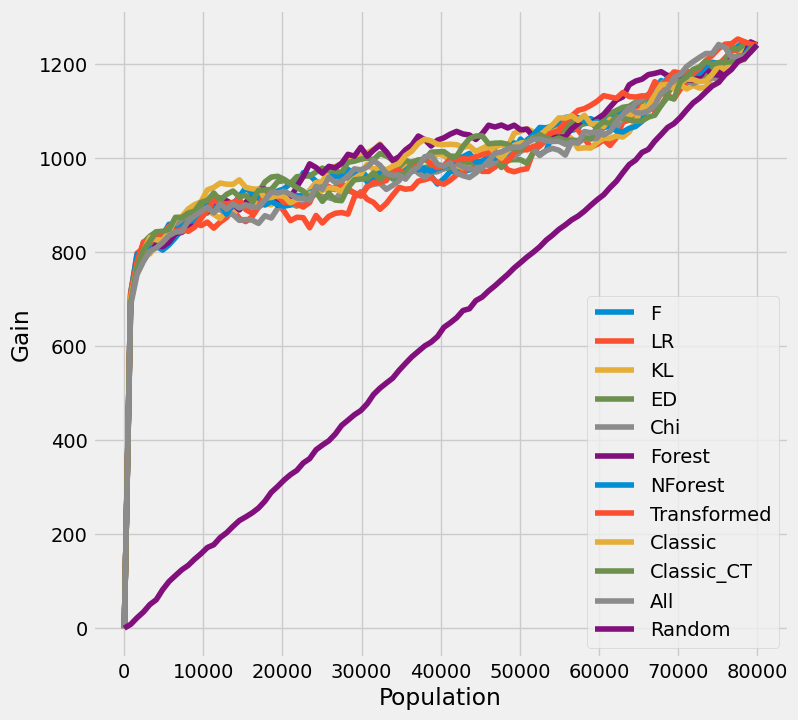

In [129]:
for key, value in s_learner_results.items():
    s_learner_results[key] = value.ravel()

s_results_for_plot = pd.DataFrame(s_learner_results)
s_results_for_plot['treatment_group_key'] = df_test['treatment_group_key']\
.map({'control': 0, 'treatment1': 1}).values
s_results_for_plot[y_name] = df_test[y_name].values

plot_gain(s_results_for_plot, outcome_col=y_name, treatment_col='treatment_group_key')

# T-Learner

In [130]:
t_learner = BaseTRegressor(learner=LGBMRegressor(max_depth=5,
                                                 n_estimators=500,
                                                 learning_rate=0.05,
                                                 verbose=-100),
                           control_name='control')

t_learner_results = get_preds_for_methods(
    model=t_learner,
    df_train=df_train,
    df_test=df_test,
    y_name=y_name,
    treatment_key='treatment_group_key',
    methods_names=methods,
    feature_lists=feature_lists
)

In [131]:
get_metrics_from_results(t_learner_results, df_test, y_name, 'treatment_group_key', treatment_name='treatment1')

,F,LR,KL,ED,Chi,Forest,NForest,Transformed,Classic,Classic_CT,All
uplift_at_10,0.108021,0.104578,0.110675,0.108303,0.110679,0.111272,0.112014,0.110993,0.110654,0.113477,0.109098
uplift_at_30,0.041129,0.043113,0.043954,0.038066,0.042990,0.040826,0.042910,0.042519,0.042370,0.038420,0.040385
qini,0.138882,0.139134,0.150215,0.121094,0.145225,0.131554,0.138971,0.141271,0.150028,0.129333,0.128424
auuc,0.022387,0.022410,0.024214,0.019530,0.023399,0.021218,0.022451,0.022893,0.024295,0.020892,0.020591


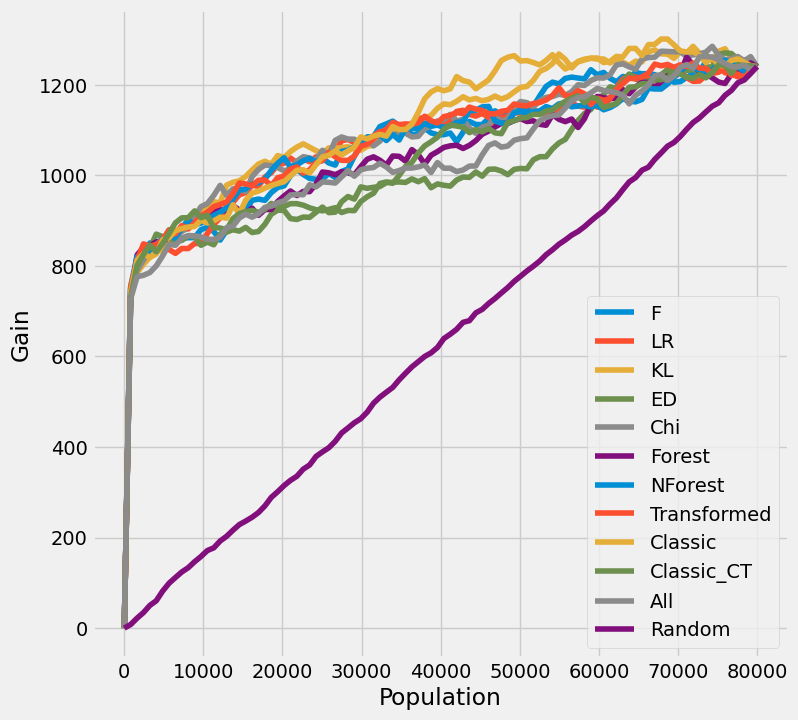

In [132]:
for key, value in t_learner_results.items():
    t_learner_results[key] = value.ravel()

t_results_for_plot = pd.DataFrame(t_learner_results)
t_results_for_plot['treatment_group_key'] = df_test['treatment_group_key']\
.map({'control': 0, 'treatment1': 1}).values
t_results_for_plot[y_name] = df_test[y_name].values

plot_gain(t_results_for_plot, outcome_col=y_name, treatment_col='treatment_group_key')

# X-learner

In [133]:
x_learner = BaseXRegressor(learner=LGBMRegressor(max_depth=5,
                                                 n_estimators=500,
                                                 learning_rate=0.05,
                                                 verbose=-100),
                           control_name='control')

x_learner_results = get_preds_for_methods(
    model=x_learner,
    df_train=df_train,
    df_test=df_test,
    y_name=y_name,
    treatment_key='treatment_group_key',
    methods_names=methods,
    feature_lists=feature_lists
)

In [134]:
get_metrics_from_results(x_learner_results, df_test, y_name, 'treatment_group_key', treatment_name='treatment1')

,F,LR,KL,ED,Chi,Forest,NForest,Transformed,Classic,Classic_CT,All
uplift_at_10,0.107477,0.111626,0.114011,0.107314,0.109349,0.106531,0.110136,0.105215,0.114144,0.105941,0.108199
uplift_at_30,0.040707,0.041495,0.041578,0.039473,0.040600,0.042439,0.043182,0.042225,0.042388,0.039056,0.041404
qini,0.138708,0.137052,0.142647,0.128618,0.136047,0.129447,0.139682,0.132974,0.140316,0.137003,0.132320
auuc,0.022320,0.022020,0.022946,0.020639,0.021867,0.020922,0.022388,0.021370,0.022649,0.022014,0.021442


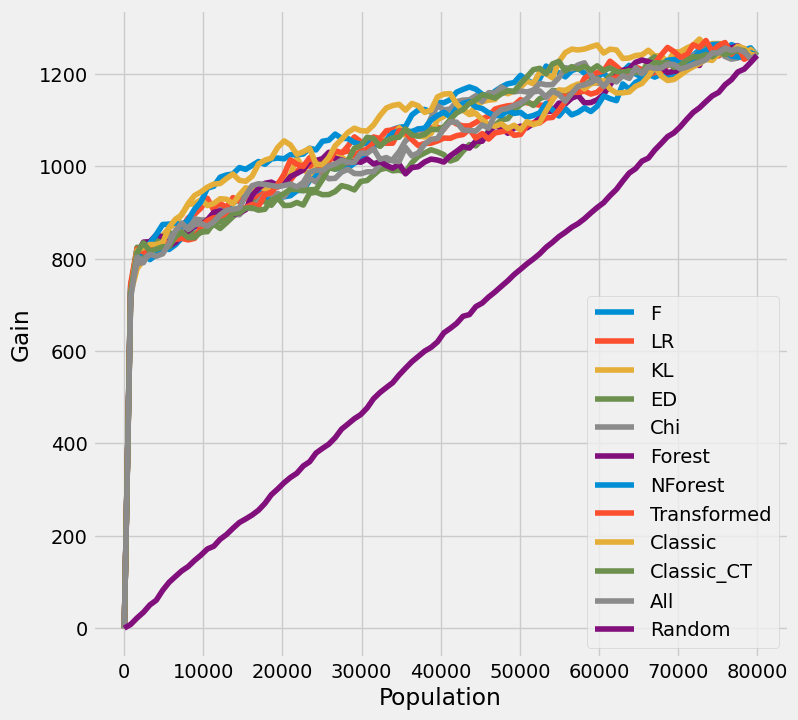

In [135]:
for key, value in x_learner_results.items():
    x_learner_results[key] = value.ravel()

x_results_for_plot = pd.DataFrame(x_learner_results)
x_results_for_plot['treatment_group_key'] = df_test['treatment_group_key']\
.map({'control': 0, 'treatment1': 1}).values
x_results_for_plot[y_name] = df_test[y_name].values

plot_gain(x_results_for_plot, outcome_col=y_name, treatment_col='treatment_group_key')

# R-learner

In [136]:
r_learner = BaseRRegressor(learner=LGBMRegressor(max_depth=5,
                                                 n_estimators=500,
                                                 learning_rate=0.05,
                                                 verbose=-100),
                           control_name='control')

r_learner_results = get_preds_for_methods(
    model=r_learner,
    df_train=df_train,
    df_test=df_test,
    y_name=y_name,
    treatment_key='treatment_group_key',
    methods_names=methods,
    feature_lists=feature_lists
)

In [137]:
get_metrics_from_results(r_learner_results, df_test, y_name, 'treatment_group_key', treatment_name='treatment1')

,F,LR,KL,ED,Chi,Forest,NForest,Transformed,Classic,Classic_CT,All
uplift_at_10,0.103220,0.108563,0.108138,0.106143,0.101043,0.108430,0.108659,0.109136,0.108734,0.108505,0.108765
uplift_at_30,0.040136,0.039765,0.040050,0.039815,0.039789,0.040211,0.041290,0.042040,0.041819,0.041154,0.042970
qini,0.133586,0.126305,0.131715,0.132447,0.128594,0.133514,0.140064,0.136350,0.138093,0.136751,0.144278
auuc,0.021411,0.020250,0.021296,0.021156,0.020707,0.021383,0.022436,0.021964,0.022361,0.022096,0.023337


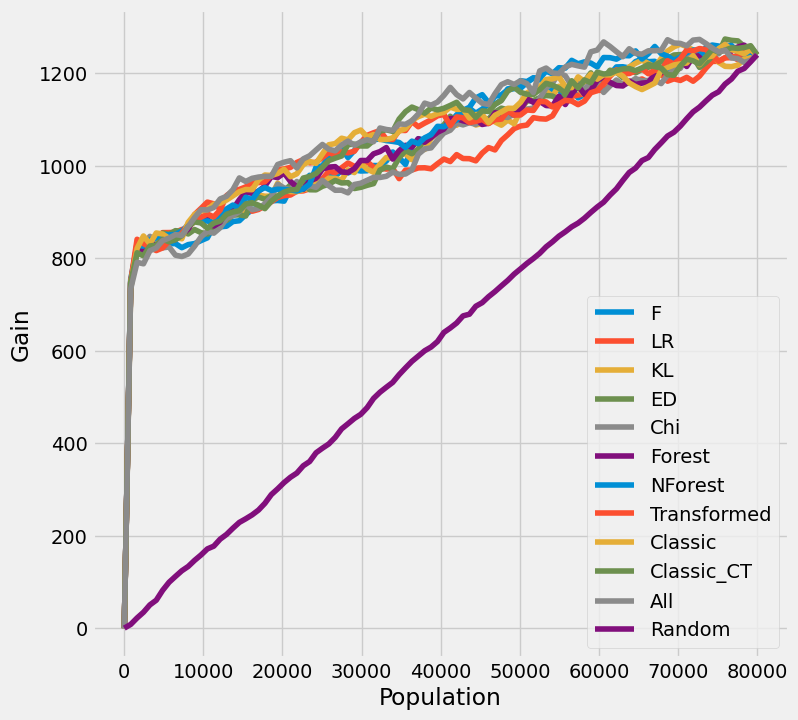

In [138]:
for key, value in r_learner_results.items():
    r_learner_results[key] = value.ravel()

r_results_for_plot = pd.DataFrame(r_learner_results)
r_results_for_plot['treatment_group_key'] = df_test['treatment_group_key']\
.map({'control': 0, 'treatment1': 1}).values
r_results_for_plot[y_name] = df_test[y_name].values

plot_gain(r_results_for_plot, outcome_col=y_name, treatment_col='treatment_group_key')

# UpliftForest

In [139]:
forest = UpliftRandomForestClassifier(control_name='control', n_estimators=20,
                                               min_samples_leaf=500, max_depth=8, random_state=random_seed)
forest.fit(X=df_train[X_names].values, treatment=df_train['treatment_group_key'].values, y=df_train[y_name].values)

forest_results = get_preds_for_methods(
    model=forest,
    df_train=df_train,
    df_test=df_test,
    y_name=y_name,
    treatment_key='treatment_group_key',
    methods_names=methods,
    feature_lists=feature_lists
)

In [140]:
get_metrics_from_results(forest_results, df_test, y_name, 'treatment_group_key', treatment_name='treatment1')

,F,LR,KL,ED,Chi,Forest,NForest,Transformed,Classic,Classic_CT,All
uplift_at_10,0.105686,0.104769,0.105033,0.103222,0.106338,0.098403,0.104735,0.104012,0.104701,0.102208,0.101409
uplift_at_30,0.036559,0.037808,0.037246,0.035758,0.038499,0.039018,0.039069,0.037050,0.036691,0.037257,0.037194
qini,0.111970,0.112366,0.108923,0.102889,0.119623,0.106096,0.111893,0.103901,0.106335,0.109892,0.107746
auuc,0.018031,0.018099,0.017639,0.016593,0.019283,0.017132,0.018057,0.016840,0.017233,0.017763,0.017456


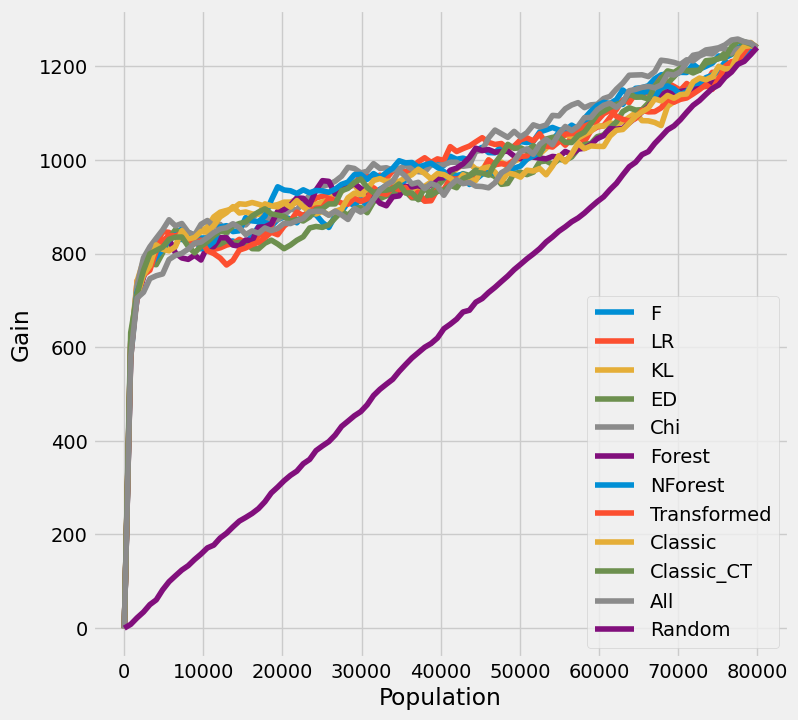

In [141]:
for key, value in forest_results.items():
    forest_results[key] = value.ravel()

forest_results_for_plot = pd.DataFrame(forest_results)
forest_results_for_plot['treatment_group_key'] = df_test['treatment_group_key']\
.map({'control': 0, 'treatment1': 1}).values
forest_results_for_plot[y_name] = df_test[y_name].values

plot_gain(forest_results_for_plot, outcome_col=y_name, treatment_col='treatment_group_key')

In [142]:
list(map(len, feature_lists))

[12, 13, 22, 13, 20, 20, 10, 9, 20, 34, 63]

In [143]:
methods

['F',
 'LR',
 'KL',
 'ED',
 'Chi',
 'Forest',
 'NForest',
 'Transformed',
 'Classic',
 'Classic_CT',
 'All']

# Как будто классика побеждает